Voy a tratar de aplicar la deteccion de outliers por lejania o distancia a los datos de este set sobre duraznos.

*Librerias*

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(123)

**Ahora leemos el csv, luego de haber corrido el from_exceltoCsv.py**

In [91]:
datos = pd.read_csv("duraznosfinal.csv")
#Eliminamos la primer columna que no nos aporta nada.
datos.drop(datos.columns[0],axis = 1, inplace = True)
datos.shape

(1186, 5)

**Tratamiento de NaN**

In [92]:
#reemplazamos los NA de finca con la moda de esa columna.
def reemplazarNAxModa(datos,columna):
    #Calculamos la moda
      moda = datos[columna].mode()
    #Rellenamos los Na con la moda.
      datos[columna] = datos[columna].fillna(moda)
      return datos
datos.isnull().sum()


Zona                      0
Finca                     0
Peso                      0
Diámetro Sutural          0
Diámetro Contrasutural    0
dtype: int64

In [93]:
def ClasificarOutliers(df,columna):
    #Creamos una serie vacia y la unimos al dataframe.
    clasif = pd.Series(dtype="int64")
    datosmod = pd.concat([df,clasif],axis=1)
    #Cambiar el nombre de la nueva columna
    datosmod.columns = [*datosmod.columns[:-1], 'Clasificacion']
    for i in range(len(datosmod[columna])):
        if(datosmod[columna][i] == 30 or datosmod[columna][i] == 20 or datosmod[columna][i] == 35 ): #Los outliers de este data set.
            datosmod["Clasificacion"][i] = 1
        else: #Sino son estos 3, entonces son 0
            datosmod["Clasificacion"][i] = 0
    return datosmod
datos_clasif = ClasificarOutliers(datos,"Peso") #Datos clasif = Datos ya clasificados como outliers
datos_clasif.head()

/tmp/ipykernel_10206/4179042019.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosmod["Clasificacion"][i] = 0
/tmp/ipykernel_10206/4179042019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosmod["Clasificacion"][i] = 1


,Zona,Finca,Peso,Diámetro Sutural,Diámetro Contrasutural,Clasificacion
0,1.0,301,147,64.0,67.0,0.0
1,1.0,1502,87,57.0,53.0,0.0
2,1.0,301,139,65.0,64.0,0.0
3,1.0,301,159,69.0,67.0,0.0
4,1.0,1502,128,64.0,62.0,0.0


**Algunos graficos para orientarnos en los valores atipicos.**


<AxesSubplot:xlabel='Zona', ylabel='Peso'>

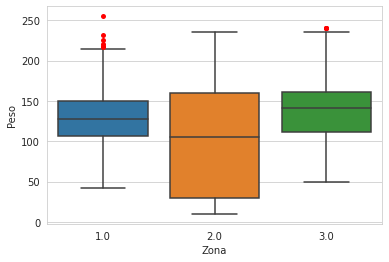

In [94]:
sns.set_style("whitegrid")
flierprops = dict(marker='o', markerfacecolor='red', markersize=5,  markeredgecolor='None')
sns.boxplot(data= datos_clasif,y = "Peso",x="Zona",flierprops = flierprops)

*Ahora que tenemos los datos limpios podemos empezar a utilizar modelos. Y comparar su perfomance.*
Probamos primero con KNN una forma de aprendizaje supervisado. Este tiene como ventaja ser muy sencillo de entender y aplicar. Tiene como desventaja su lentitud y que solamente encuentra anomalias globales y no locales. La eleccion de K es muy importante para un correcto funcionamiento del algoritmo, pero se trata de una variable que depende enteramente de cada set de datos.

In [95]:
#Arrancariamos con KNN.
from pyod.models.knn import KNN 
from sklearn.model_selection import train_test_split 
from pyod.utils.data import evaluate_print

In [96]:
# split into independent variables and target variable
x = datos_clasif.drop(['Zona','Finca','Clasificacion'], axis=1) 
y = datos_clasif['Clasificacion']  
# show the shape of x and y  
print("x shape: {}".format(x.shape)) 
print("y shape: {}".format(y.shape))

x shape: (1186, 3)
y shape: (1186,)


In [97]:
#Vamos a analizar el peso y cuales son outliers
#Mantenemos la notacion de x como input e y como output.
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify = y, random_state = 42)

print(f"x_train : {x_train.size},\n x_test: {len(x_test)},\n y_train: {len(y_train)},\n y_test :{len(y_test)}")

x_train : 2844,
 x_test: 238,
 y_train: 948,
 y_test :238


In [98]:
clf_knn = KNN(contamination= 0.172,n_neighbors = 5,n_jobs=-1)
#Entrenamos el modelo con datos de entrenamiento
clf_knn.fit(x_train)


KNN(algorithm='auto', contamination=0.172, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)

In [99]:
#Esto nos devuelve las etiquetas del entrenamiento de los datos
y_train_pred = clf_knn.labels_
#Obtenemos su puntaje
y_train_scores = clf_knn.decision_scores_
print(f"y_train : {y_train.size}, y_train_scores:{y_train_scores.size}")

y_train : 948, y_train_scores:948


In [100]:
# Evaluate on the training data 
evaluate_print('KNN', y_train, y_train_scores)

KNN ROC:0.3293, precision @ rank n:0.0364


In [101]:
y_test_scores = clf_knn.decision_function(x_test)  # outlier scores
# Evaluate on the training data
evaluate_print('KNN', y_test,y_test_scores)

KNN ROC:0.4088, precision @ rank n:0.0714


Como podemos observar el KNN ROC en ambos casos es bastante pobre. Mis dos teorias son:

    1.Los datos son muy pocos para un correcto entrenamiento de la IA
    2.Puede que el clasificador este funcionando mal, osea que los datos esten mal clasificados antes del entrenamiento. Entonces por eso sea malo el entrenamiento.

